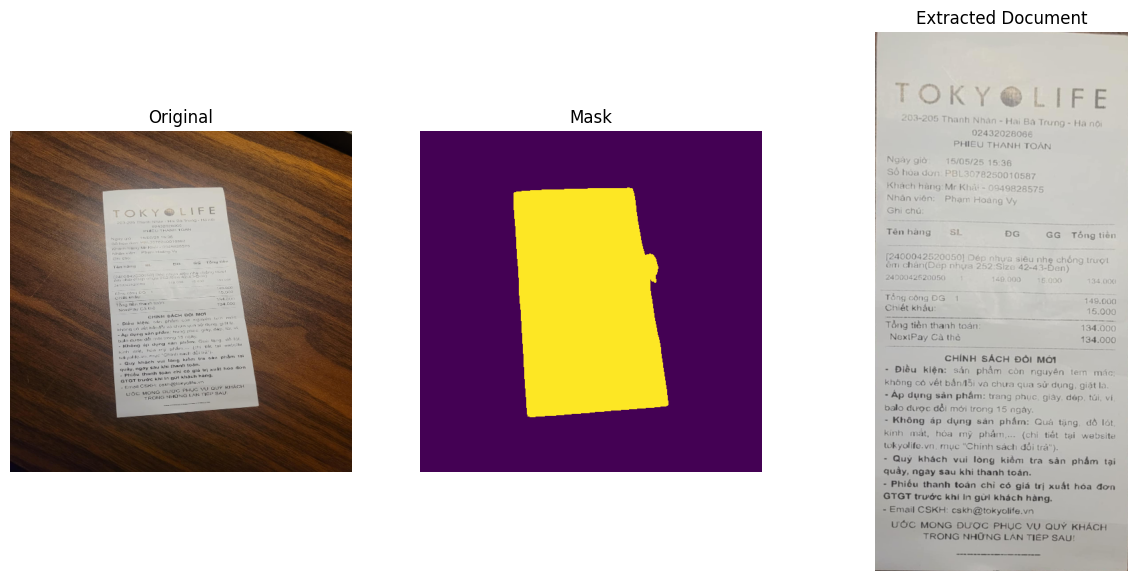

In [ ]:
import torch
import cv2
import numpy as np
import segmentation_models_pytorch as smp
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import logging

IMG_SIZE = (512, 512)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize and load model
model = smp.Unet(
    encoder_name="resnet50",
    encoder_weights="imagenet",
    in_channels=3,
    classes=1,
    activation=None
).to(device)

model_path = r"D:\HUST\2024.2\Computer Vision\Project\Final_Code\Model\best_segmentation_unet_resnet50_vaipep (1).pth"
try:
    model.load_state_dict(torch.load(model_path, map_location=device))
    logging.info(f"Loaded model weights from {model_path}")
except Exception as e:
    logging.error(f"Failed to load model weights: {e}")
    raise

def order_points(pts):
    rect = np.zeros((4, 2), dtype=np.float32)
    s = pts.sum(axis=1)
    rect[0], rect[2] = pts[np.argmin(s)], pts[np.argmax(s)]
    diff = np.diff(pts, axis=1)
    rect[1], rect[3] = pts[np.argmin(diff)], pts[np.argmax(diff)]
    return rect

def find_dest(corners):
    width = max(np.linalg.norm(corners[0] - corners[1]), np.linalg.norm(corners[2] - corners[3]))
    height = max(np.linalg.norm(corners[0] - corners[3]), np.linalg.norm(corners[1] - corners[2]))
    return np.array([[0, 0], [width - 1, 0], [width - 1, height - 1], [0, height - 1]], dtype=np.float32)

def extract_document(image, model, image_size=(488, 488), buffer=10):
    imH, imW, _ = image.shape
    half = image_size[0] // 2
    scale_x, scale_y = imW / image_size[0], imH / image_size[1]

    image_resized = cv2.resize(image, image_size, interpolation=cv2.INTER_NEAREST)
    image_tensor = transforms.ToTensor()(image_resized).unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
        pred_mask = torch.sigmoid(model(image_tensor)).squeeze().cpu().numpy()

    mask = (pred_mask > 0.5).astype(np.uint8) * 255
    extended_shape = (image_size[0] + mask.shape[0], image_size[1] + mask.shape[1])
    mask_extended = np.zeros(extended_shape, dtype=mask.dtype)
    mask_extended[half:half + image_size[0], half:half + image_size[1]] = mask

    canny = cv2.Canny(mask_extended, 225, 255)
    canny = cv2.dilate(canny, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5)))
    contours, _ = cv2.findContours(canny, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
    if not contours:
        raise ValueError("No contours found in the image.")
    page = sorted(contours, key=cv2.contourArea, reverse=True)[0]

    epsilon = 0.02 * cv2.arcLength(page, True)
    corners = cv2.approxPolyDP(page, epsilon, True)
    corners = np.concatenate(corners).astype(np.float32)
    corners[:, 0] = (corners[:, 0] - half) * scale_x
    corners[:, 1] = (corners[:, 1] - half) * scale_y

    image_true = image.astype(np.float32)
    if not (np.all(corners.min(axis=0) >= (0, 0)) and np.all(corners.max(axis=0) <= (imW, imH))):
        rect = cv2.minAreaRect(corners.reshape((-1, 1, 2)))
        box = cv2.boxPoints(rect)
        box_corners = np.int32(box)

        left_pad = max(0, -box_corners[:, 0].min()) + buffer
        right_pad = max(0, box_corners[:, 0].max() - imW) + buffer
        top_pad = max(0, -box_corners[:, 1].min()) + buffer
        bottom_pad = max(0, box_corners[:, 1].max() - imH) + buffer

        new_shape = (imH + top_pad + bottom_pad, imW + left_pad + right_pad, image.shape[2])
        image_extended = np.zeros(new_shape, dtype=image.dtype)
        image_extended[top_pad:top_pad + imH, left_pad:left_pad + imW, :] = image_true
        image_true = image_extended
        box_corners[:, 0] += left_pad
        box_corners[:, 1] += top_pad
        corners = box_corners.astype(np.float32)

    corners = order_points(corners)
    destination_corners = find_dest(corners)
    M = cv2.getPerspectiveTransform(corners, destination_corners)
    final = cv2.warpPerspective(image_true, M, (int(destination_corners[2][0]), int(destination_corners[2][1])), flags=cv2.INTER_LANCZOS4)
    return np.clip(final, 0, 255).astype(np.uint8), pred_mask

def visualize_segmentation(img, mask, extracted, threshold=0.5):
    if mask.max() <= 1.0:
        mask = (mask > threshold).astype(np.uint8)
    
    fig = plt.figure(figsize=(15, 7))
    ax1 = fig.add_subplot(131)
    ax1.imshow(img)
    ax1.set_title("Original")
    ax1.axis("off")
    
    ax2 = fig.add_subplot(132)
    ax2.imshow(mask)
    ax2.set_title("Mask")
    ax2.axis("off")
    
    ax3 = fig.add_subplot(133)
    ax3.imshow(extracted)
    ax3.set_title("Extracted Document")
    ax3.axis("off")
    plt.show()

if __name__ == "__main__":
    img_path = r"D:\HUST\2024.2\Computer Vision\Project\Final_Code\TestImage\419fb63b-16e9-4685-95e1-7e49588c9a70.jpg"
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img, IMG_SIZE)

    extracted_doc, pred_mask = extract_document(img, model, image_size=IMG_SIZE)
    visualize_segmentation(img_resized, pred_mask, extracted_doc)